VJP for $h(x)=\sin{x}$

In [1]:
import jax.numpy as jnp
from jax import custom_vjp

@custom_vjp
def h(x):
    return jnp.sin(x)

def h_fwd(x):
    return h(x), jnp.cos(x)

def h_bwd(res, u):
    cos_x  = res 
    return (cos_x * u,)

h.defvjp(h_fwd, h_bwd)

from jax import grad, vmap
gv=vmap(grad(h))
hv=vmap(h)

In [2]:
xv=jnp.linspace(-1,1,10)
print(hv(xv),gv(xv))

[-0.84147096 -0.7016979  -0.5274154  -0.32719466 -0.11088265  0.11088268
  0.32719472  0.5274154   0.7016979   0.84147096] [0.5403023  0.71247464 0.8496075  0.94495696 0.9938335  0.9938335
 0.94495696 0.8496075  0.71247464 0.5403023 ]


In [3]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(32)
sigin=0.3
N=20
x=np.sort(np.random.rand(N))*4*np.pi
data=hv(x)+np.random.normal(0,sigin,size=N)

plt.plot(x,data,".")
plt.savefig("test.png")
plt.show()

<Figure size 640x480 with 1 Axes>

In [4]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(x,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    x0 = numpyro.sample('x0', dist.Uniform(-1.,1.))
    #mu=jnp.sin(x-x0)
    #mu=hv(x-x0)
    mu=h(x-x0)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [5]:
from jax import random
from numpyro.infer import MCMC, NUTS

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, x=x, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:10<00:00, 280.58it/s, 7 steps of size 7.98e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.35      0.06      0.34      0.26      0.45   1014.77      1.00
        x0      0.07      0.11      0.07     -0.10      0.26   1028.72      1.00

Number of divergences: 0


VJP $h(x,y)=A \sin{x}$

In [6]:
from jax import custom_vjp, vmap, grad
import jax.numpy as jnp
@custom_vjp
def h(x,A):
    return A*jnp.sin(x)

def h_fwd(x, A):
    res = (A*jnp.cos(x), jnp.sin(x))
    return h(x,A), res

def h_bwd(res, u):
    A_cos_x, sin_x = res
    return (A_cos_x * u, sin_x * u)

h.defvjp(h_fwd, h_bwd)

gv=vmap(grad(h),(0,None),0)
gav=vmap(grad(h),(None,0),0)
hv=vmap(h,(0,None),0)

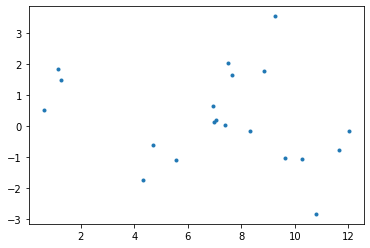

In [7]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(32)
sigin=1.0
N=20
x=np.sort(np.random.rand(N))*4*np.pi
data=hv(x,1.0)+np.random.normal(0,sigin,size=N)

plt.plot(x,data,".")
plt.savefig("test.png")
plt.show()

In [8]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(x,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    x0 = numpyro.sample('x0', dist.Uniform(-1.,1.))
    A = numpyro.sample('A', dist.Exponential(1.))
    hv=vmap(h,(0,None),0)
    mu=hv(x-x0,A)
    #mu=A*jnp.sin(x-x0)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [11]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
kernel = NUTS(model)
#kernel = NUTS(model,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, x=x, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:06<00:00, 439.62it/s, 7 steps of size 6.67e-01. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      1.34      0.36      1.35      0.76      1.91   1038.63      1.00
     sigma      1.12      0.20      1.09      0.82      1.43    989.39      1.00
        x0      0.21      0.28      0.24     -0.27      0.64   1577.08      1.00

Number of divergences: 0


In [10]:
#Primitiveから構成する
#see https://jax.readthedocs.io/en/latest/notebooks/How_JAX_primitives_work.html
from jax import core
from jax.interpreters import ad
import numpy as np  
from jax.core import Primitive
from jax.interpreters.ad import defvjp
from jax.interpreters import batching
from jax import abstract_arrays
from jax.lib import xla_client
from jax.interpreters import xla

def h(x):
    return jnp.sin(x)

def dh(x):
    return jnp.cos(x)

def udsin(x):
    return foo_p.bind(x)
foo_p = Primitive('udsin')
foo_p.def_impl(h)

def dudsin(g, x):
    return g*dh(x)
defvjp(foo_p, dudsin)

#vmapを使うためにはbatching ruleが必要
def foo_batch(vector_arg_values, batch_axes):
    res = udsin(*vector_arg_values)
    return res, batch_axes[0]

batching.primitive_batchers[foo_p] = foo_batch

#jitを使うためにはabstract evaluation ruleが必要
def foobar_abstract_eval(xs):
    return abstract_arrays.ShapedArray(xs.shape, xs.dtype)

foo_p.def_abstract_eval(foobar_abstract_eval)

# jitを使うにはXLA compilation ruleも必要
# xla_client.pyはtensorflowのもの
def foo_xla_translation(c, xc):
    return xla_client.ops.Sin(xc)
xla.backend_specific_translations['gpu'][foo_p] = foo_xla_translation

In [11]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(x,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    x0 = numpyro.sample('x0', dist.Uniform(-1.,1.))
    mu=udsin(x-x0)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [12]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, x=x, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:09<00:00, 314.33it/s, 3 steps of size 8.56e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     sigma      0.35      0.06      0.34      0.25      0.45    992.06      1.00
        x0      0.07      0.12      0.07     -0.11      0.27   1498.10      1.00

Number of divergences: 0
